# Analyse de l'influence des distributions des temps inter-véhiculaires sur un axe routier

Paramètres de simulation:
- 1 voie
- longueur de la voie : 15900 m
- présence d'outils de contrôle de la circulation : non
- paramètres de distribution 
    <br/> dn -> N(8.33, 1) [m]
    <br/> longueur -> N(7, 1) [m]
    <br/> vitesse -> N(14, 3) [m.s^-1]
    <br/> t -> N(2, 0.5) [s]
- durée de la simulation : 500 s = 5000 1/10s   
- seed pour reproductibilité : 45

import des librairies:

In [1]:
import numpy as np  
import network, simulation, toolkit
import makesimulation 
import matplotlib.pyplot as plt
import analysis
import statistics
import seaborn
from trafficintelligence import events, moving

OpenCV library could not be loaded (video replay functions will not be available)
OpenCV library could not be loaded (video replay functions will not be available)


Récupération des fichiers initiaux

In [2]:
world = network.World.load('simple-net.yml')  
sim = simulation.Simulation.load('config.yml')

- headways -> Exp(1.8, 1)
</br> On décalle la distribution à 1s % les temps inter-véhiculaires produits ne seront pas inférieurs à cette valeur

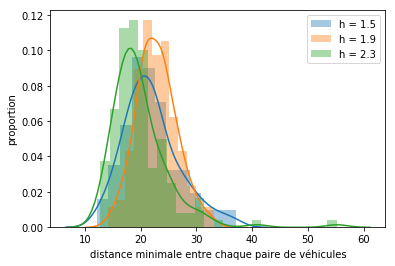

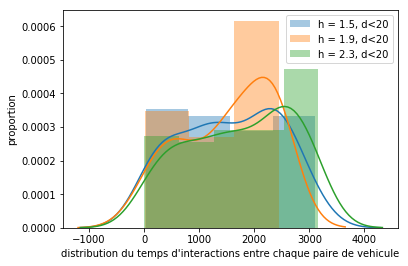

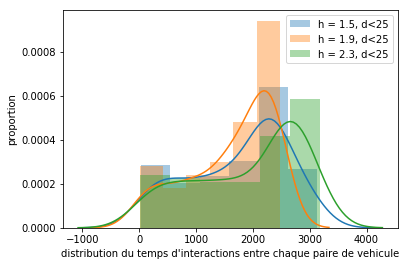

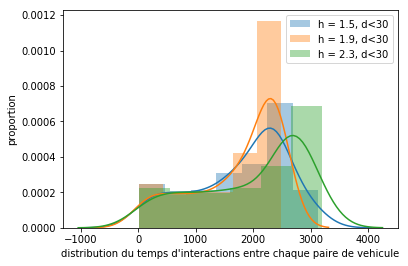

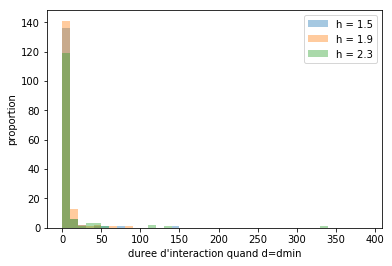

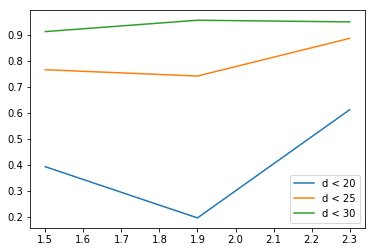

In [4]:
# liste des seeds a tester
seeds = [45,46]#,46]#,47,48,49,50]


for seed in seeds:
    sim.seed = seed

    # liste des headways a essayer:
    headways = [1.5, 1.9, 2.3]#, 2.2, 2.3, 2.5]#, 1.6, 1.8, 2, 2.2]#, 2.4, 2.6, 2.8]
    cList = []
    fig0 = plt.figure(num=0)
    cList = {}
    durationList = {}
    durationList2 = {}
    count = {}
    
    for h in headways:
        # modification des paramètres dans simple-net.yml
        world = network.World.load('simple-net.yml')  
        world.userInputs[0].distributions['headway'].scale = h-world.userInputs[0].distributions['headway'].loc

        # running the simulation
        world = makesimulation.run(world, sim)
        
        # distribution des distances minimales d'interaction
        interactions = []
        # 1ere etape : recuperer la liste des interactions entre chaque paire de vehicules
        for k in range(len(world.userInputs[0].alignment.users)-1):
            roadUser1 = world.userInputs[0].alignment.users[k]
            roadUser2 = world.userInputs[0].alignment.users[k+1]
            if roadUser1.timeInterval is not None and roadUser2.timeInterval is not None:
                i = events.Interaction(useCurvilinear=True, roadUser1=roadUser1, roadUser2=roadUser2)
                i.computeIndicators(world=world, alignment1=world.travelledAlignments(roadUser1), alignment2=world.travelledAlignments(roadUser2)) 
                interactions.append(i)
        
        # recupérer la valeur minimale des distances entre chaque paire de vehicule 
        minDistances = [min(i.indicators['Distance'].values.values()) for i in interactions]
        plt.figure(num=0)
        ax = seaborn.distplot(minDistances, rug=False, hist=True, label='h = '+str(h)+'seed = '+str(seed), norm_hist=True)
        # pour chaque tiv testé on obtient la distribution des distances minimales entre chaque paire de véhicules
        plt.xlabel("distance minimale entre chaque paire de véhicules")
        plt.ylabel("proportion")
        ax.legend()
               
        minDistances = [20,25,30]
        cList[h] = {}
        
        for distance in minDistances:
            duration = []
            # rapport durée interaction
            for i in interactions:
                interactionLength = []
                for t in list(i.timeInterval):
                    if i.indicators['Distance'].values[t] < distance:
                        interactionLength.append(1)
                    else:
                        interactionLength.append(0)
                interactionDuration = sum(toolkit.makeSubListFromList(interactionLength, 1))
    #             interactionDuration = interactionDuration / len(list(i.timeInterval))
                duration.append(interactionDuration)
            durationList[h] = list(filter(lambda v: v !=0, duration))
            plt.figure(num=distance)
            ax=seaborn.distplot(durationList[h], rug=False, hist=True, label='h = '+str(h)+', d<'+str(distance)+'seed = '+str(seed), norm_hist=False)
            plt.xlabel("distribution du temps d'interactions entre chaque paire de vehicule")
            plt.ylabel("proportion")
            ax.legend()
            
        
        durationList2[h] = []
        # #############################################################333
        for i in interactions:
            duration2 = []
            interactionLength2 = []

            for t in list(i.timeInterval):

                if i.indicators['Distance'].values[t] == min(i.indicators['Distance'].values.values()):
                    interactionLength2.append(1)
                else:
                    interactionLength2.append(0)
        #     print(interactionLength2)
            interactionDuration2 = sum(toolkit.makeSubListFromList(interactionLength2, 1))
            durationList2[h].append(interactionDuration2)

        plt.figure('distance min')
        plt.hist(durationList2[h], label='h = '+str(h)+'seed = '+str(seed), density=False, bins=[k for k in range(0,400,10)], alpha=.4)
        plt.xlabel("duree d'interaction quand d=dmin")
        plt.ylabel("proportion")
        plt.legend()
        
        count[h] = {}
        for distance in minDistances:
            count[h][distance] = 0
            for i in interactions:
                interactionLength = []
                for t in list(i.timeInterval):
                    if i.indicators['Distance'].values[t] < distance:
                        interactionLength.append(1)
                    else:
                        interactionLength.append(0)
                count[h][distance] += toolkit.countElementInList(interactionLength, 1)
            count[h][distance] /= len(world.getNotNoneVehiclesInWorld()[0])
                
    count = toolkit.inverseDict(count, headways, minDistances)
    plt.figure('compte')
    for el in count:
        plt.plot(list(count[el].keys()), list(count[el].values()), label='d < '+str(el)+'seed = '+str(seed))
        plt.legend()
    

toolkit.callWhenDone()